
# MACHINE LEARNING - PROJET
Adèle Imparato, Christina Maurin, Norman Hutte, Nicolas Luciani

In [65]:
from google.colab import drive
import sys
drive.mount('/content/gdrive/')
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/MachineLearning'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/MachineLearning


'/content/gdrive/My Drive/Colab Notebooks/MachineLearning'

Tout d'abord, on importe les librairies nécessaires.

In [66]:
!pip install contractions

import sklearn

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')

import numpy as np
import pandas as pd
import contractions
import matplotlib as mpl
import matplotlib.pyplot as plt

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample

from PIL import Image

from wordcloud import WordCloud, STOPWORDS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Ensuite, on lit les données (training set). On lira le testing set une fois qu'on aura trouvé un modèle de classification et qu'il faudra le tester.

In [67]:
training_data = pd.read_csv("HAI817_Projet_train.csv")
training_data.head()

,public_id,text,title,our rating
0,5a228e0e,Distracted driving causes more deaths in Canad...,"You Can Be Fined $1,500 If Your Passenger Is U...",false
1,30c605a1,Missouri politicians have made statements afte...,Missouri lawmakers condemn Las Vegas shooting,mixture
2,c3dea290,Home Alone 2: Lost in New York is full of viol...,CBC Cuts Donald Trump's 'Home Alone 2' Cameo O...,mixture
3,f14e8eb6,But things took a turn for the worse when riot...,Obama’s Daughters Caught on Camera Burning US ...,false
4,faf024d6,It’s no secret that Epstein and Schiff share a...,Leaked Visitor Logs Reveal Schiff’s 78 Visits ...,false


In [68]:
training_data.tail()

,public_id,text,title,our rating
1259,47423bb6,More than four million calls to the taxman are...,Taxman fails to answer four million calls a ye...,true
1260,097c142a,More under-18s are being taken to court for se...,Police catch 11‑year‑olds being used to sell d...,true
1261,08bc59f4,The Government’s much vaunted Help to Buy Isa ...,"Help to Buy Isa scandal: 500,000 first-time bu...",false
1262,af3393ce,The late Robin Williams once called cocaine “G...,A coke-snorting generation of hypocrites,true
1263,a39d07df,The late Robin Williams once called cocaine “G...,A coke-snorting generation of hypocrites,true


In [69]:
training_data.shape

(1264, 4)

## Phase de preprocessing
Durant cette phase, on va créer plusieurs fonctions permettant de prétraiter nos données. Voici ces fonctions:
- contractions (e.g. it's := it is)
- get regex tokens
- lower casing
- process numbers
- remove stop words
- remove indesirable words
- lemmatization

Après ça, on va pouvoir créer des dataframes contenant nos données textuelles prétraitées par des combinaisons de nos méthodes (pour tester quelles méthodes sont les plus efficaces).

Nous cherchons à présent, à traiter les contractions présentes au sein de nos textes.

In [70]:
def processContractions(data) :
  text_to_tokenize = []
  for text_content in data.text :
    phrase = contractions.fix(text_content)
    text_to_tokenize.append(phrase)
  return text_to_tokenize

Prétraitons maintenant les données. On commence par mettre tous les mots en minuscules. Pour cela, trouvons d'abord la liste des mots (tokens) contenues dans les textes à traiter.

In [71]:
tokenizer = RegexpTokenizer(r"(\w+|#\d|\?|!)|.|:|;")

def getRegexTokens(data_texts):
  tokens = []

  for text_content in data_texts:
    regex = tokenizer.tokenize(text_content) 
    #print(regex)
    for reg in regex:
      if not reg == '':
        tokens.append(reg)
        
  return tokens

In [72]:
#for text_content in training_data.text:
#  for token in text_content.split():
#    tokens.append(token)

In [73]:
def getRegexTokens4oneText(one_text):
  tokens = []

  regex = tokenizer.tokenize(one_text) 
  for reg in regex:
    if not reg == '':
      tokens.append(reg)
        
  return tokens

In [74]:
def allToLowerCase(tokens):
  for i in range(len(tokens)):
    tokens[i] = tokens[i].lower()
  return tokens

Traitement des valeurs numériques en "number"

In [75]:
def processNumbers(tokens):
  processed_tokens = ["number" if token.isnumeric() else token for token in tokens]
  return processed_tokens

Après, on élimine les 'stops-words' en anglais. Ceux-ci n'apportent généralement pas (ou très peu) de significtion au texte.


In [76]:
def removeStopWords(tokens):
  stop_words = set(stopwords.words('english'))
  text_without_stopWords = [word for word in tokens if not word in stop_words]
  return text_without_stopWords

def removeIndesirableWords(tokens):
  indesirable_list = ['!','?','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
  text_without_indesirables = [word for word in tokens if not word in indesirable_list]
  return text_without_indesirables

On va maintenant faire de la lemmatization, ce qui va permettre de garder le racine des mots utiliser afin de la comparer plus facilement et de réduire la taille du vocabulaire.

In [77]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [78]:
def createVoc(tokens):
  out = {}
  for token in tokens:
    if token in out.keys():
      out[token] += 1
    else:
      out[token] = 1
  return out

In [79]:
# première methode de preprocessing
# contraction, regex, lower case, process numbers, 
# remove stop words, remove indesirable words, lemmatization
def preprocess1(data):

  newData = pd.DataFrame()
  lemma = WordNetLemmatizer()
  for i in range(len(data.text)):
    temp = getRegexTokens4oneText(data.text.iloc[i])
    temp = allToLowerCase(temp)
    temp = processNumbers(temp)
    temp = removeStopWords(temp)
    temp = removeIndesirableWords(temp)
    for j in range(len(temp)):
      temp[j] = lemma.lemmatize(temp[j], pos=get_wordnet_pos(temp[j]))
    s = " ".join(temp)
    newData.at[i, 'text'] = s
  return newData

In [80]:
# deuxième methode de preprocessing
# c'est ici qu'on va tester différentes combinaisons de méthodes de preprocessing
def preprocess2(data):

  newData = pd.DataFrame()
  lemma = WordNetLemmatizer()
  for i in range(len(data.text)):
    temp = getRegexTokens4oneText(data.text.iloc[i])
    temp = allToLowerCase(temp)
    #temp = processNumbers(temp)
    temp = removeStopWords(temp)
    #temp = removeIndesirableWords(temp)

    for j in range(len(temp)):
      temp[j] = lemma.lemmatize(temp[j], pos=get_wordnet_pos(temp[j]))
    
    s = " ".join(temp)
    newData.at[i, 'text'] = s
  return newData

In [81]:
def createVocToDF(data):
  tokens = []
  
  for text_content in data.text:
    for token in text_content.split():
      tokens.append(token)

  # create vocabulary after preprocessing
  voc_after_prepro = createVoc(tokens)

  data_items = voc_after_prepro.items()
  data_list = list(data_items)
  df = pd.DataFrame(data_list)

  #df.to_csv('vocabulary_after_preprocessing.csv')
  return df

Maintenant on va juste appliquer ces méthodes de préprocessing sur nos données de différentes manières.

In [82]:
# on applique la contraction de mots d'office dès le début
td_contracted = training_data.copy()
td_contracted.text = processContractions(td_contracted)

# données avec toutes les méthodes de preprocessing appliquées
td_preprocessed1 = td_contracted.copy()
td_preprocessed1.text = preprocess1(td_preprocessed1)

In [83]:
print(td_preprocessed1.text[0])

distract drive cause death canada impaired drive every province territory law drive operating cell phone tell passenger stay phone drive measure necessary distract drive claimed life impaired drive province like british columbia ontario quebec alberta nova scotia manitoba newfoundland labrador mobile phone even held passenger dangerous distraction driver start next week distract screen held passenger attracts penalty number number three demerit point driver screen mix matter hold device use facetime take selfies driver show driver funny cat video province mobile phone categorise visual display unit meaning consider akin television screen important practice safe drive sake fellow driver canada crack distract drive problem rollout stricter law impose harsher penalty heftier fine guilty offender take effect next week add serious penalty convict distract drive


In [84]:
# total vocabulary from all texts (preprocessed1)
df_preprocessed1 = createVocToDF(td_preprocessed1)
df_preprocessed1.head()

,0,1
0,distract,16
1,drive,221
2,cause,547
3,death,646
4,canada,123


In [85]:
td_preprocessed2 = td_contracted.copy()
td_preprocessed2.text = preprocess2(td_preprocessed2)

In [86]:
print(td_preprocessed2.text[0])

distract drive cause death canada impaired drive every province territory law drive operating cell phone tell passenger stay phone drive measure necessary distract drive claimed life impaired drive province like british columbia ontario quebec alberta nova scotia manitoba newfoundland labrador mobile phone even held passenger dangerous distraction driver start next week distract screen held passenger attracts penalty 1 500 three demerit point driver screen mix matter hold device use facetime take selfies driver show driver funny cat video province mobile phone categorise visual display unit meaning consider akin television screen important practice safe drive sake fellow driver canada crack distract drive problem rollout stricter law impose harsher penalty heftier fine guilty offender take effect next week add serious penalty convict distract drive


## Visualisations
Dans cette phase de visualitions on va afficher des informations pertinentes comme les mots récurrents d'une certaine classe, ou encore la taille du dictionnaire avant et après prétraitement, etc.

Tout d'abord, créons des dictionnaires pour les labels False/True/Mixture/Other. Cela va nous permettre d'identifier les mots clés d'une classe et d'une autre.

In [87]:
def createTrueFalseVoc(data):
  false_voc = {}
  true_voc = {}
  mixt_voc = {}
  other_voc = {}
  for i in range(len(data.text)):
    temp = data.text.iloc[i].split()
    if data['our rating'].iloc[i] == 'false':
      for token in temp:
        if token in false_voc:
          false_voc[token] += 1
        else:
          false_voc[token] = 1
    elif data['our rating'].iloc[i] == 'true':
      for token in temp:
        if token in true_voc:
          true_voc[token] += 1
        else:
          true_voc[token] = 1
    elif data['our rating'].iloc[i] == 'mixture':
      for token in temp:
        if token in mixt_voc:
          mixt_voc[token] += 1
        else:
          mixt_voc[token] = 1
    elif data['our rating'].iloc[i] == 'other':
      for token in temp:
        if token in other_voc:
          other_voc[token] += 1
        else:
          other_voc[token] = 1
  return false_voc, true_voc, mixt_voc, other_voc

In [88]:
false_voc, true_voc , mixt_voc, other_voc = createTrueFalseVoc(td_preprocessed1)

In [1]:
#print(false_voc)

In [2]:
#print(true_voc)

In [3]:
#print(mixt_voc)

In [ ]:
#print(other_voc)

In [93]:
# WORD CLOUD

cmap_O = mpl.cm.Oranges(np.linspace(0,1,20))
cmap_O = mpl.colors.ListedColormap(cmap_O[10:,:-1])

#Font parameters for our Title
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 36,}

# Mask for the Word Cloud
stop_words=set(STOPWORDS)
stop_words.add("number")
stop_words.add("say")

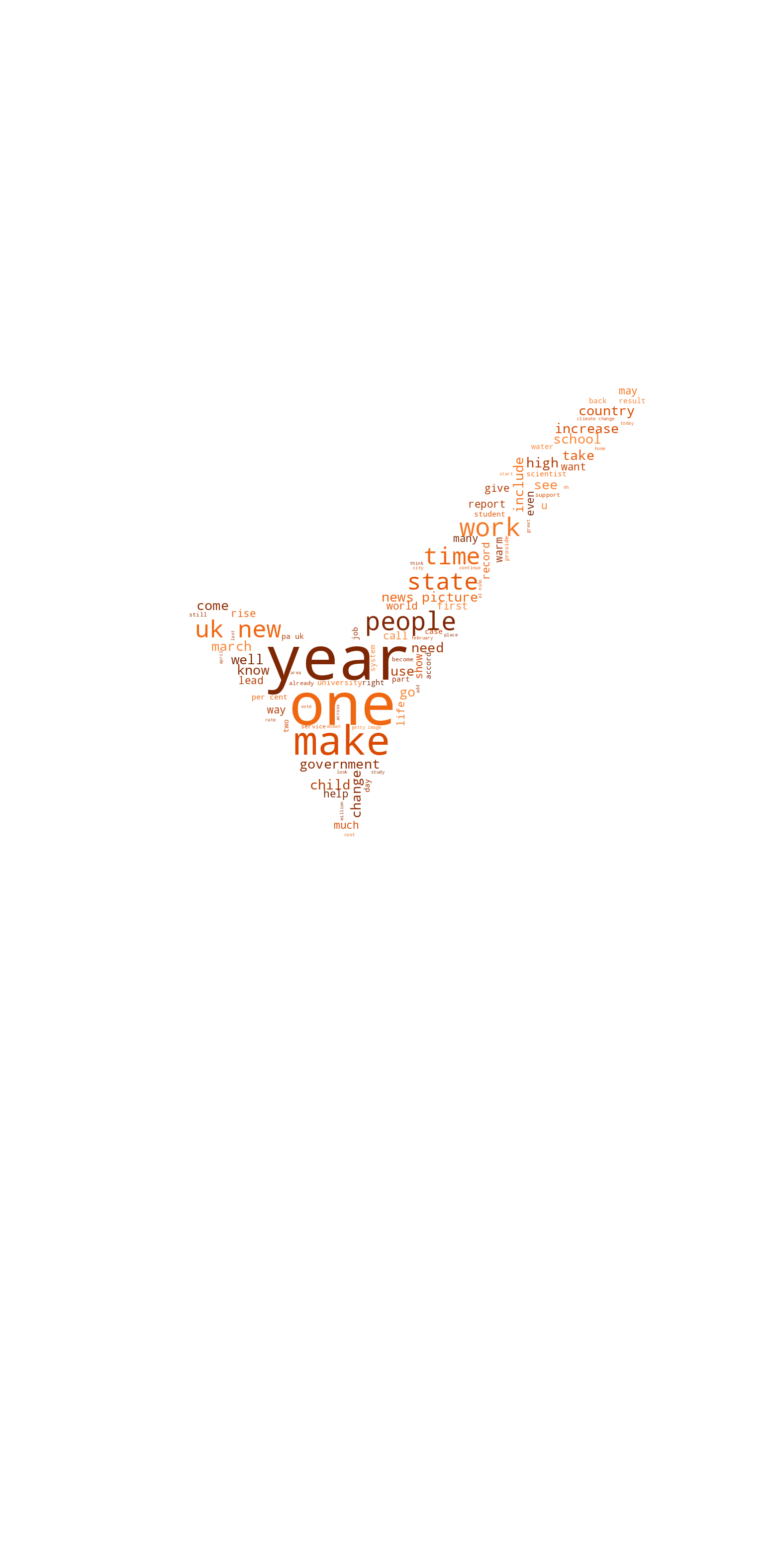

In [94]:
# WORD CLOUD TRUE VOC

cb_mask_TRUE = np.array(Image.open('yes.jpg'))

#Creating variable with data for this Word Cloud
temp = td_preprocessed1[td_preprocessed1['our rating'] == 'true']
textS = ' '.join(temp['text'].tolist())

cb_wc=WordCloud(width=400,height=200,mask=cb_mask_TRUE,random_state=101, max_font_size=450,
                 min_font_size=3,stopwords=stop_words,background_color="white",
                 scale=3,max_words=200,collocations=True,colormap=cmap_O)

#Generate it
cb_wc.generate(str(textS))

fig=plt.figure(figsize=(20,20))
plt.ylim(-400,2700)
plt.gca().invert_yaxis()
plt.axis("off")
plt.imshow(cb_wc,interpolation='bilinear')
plt.show()

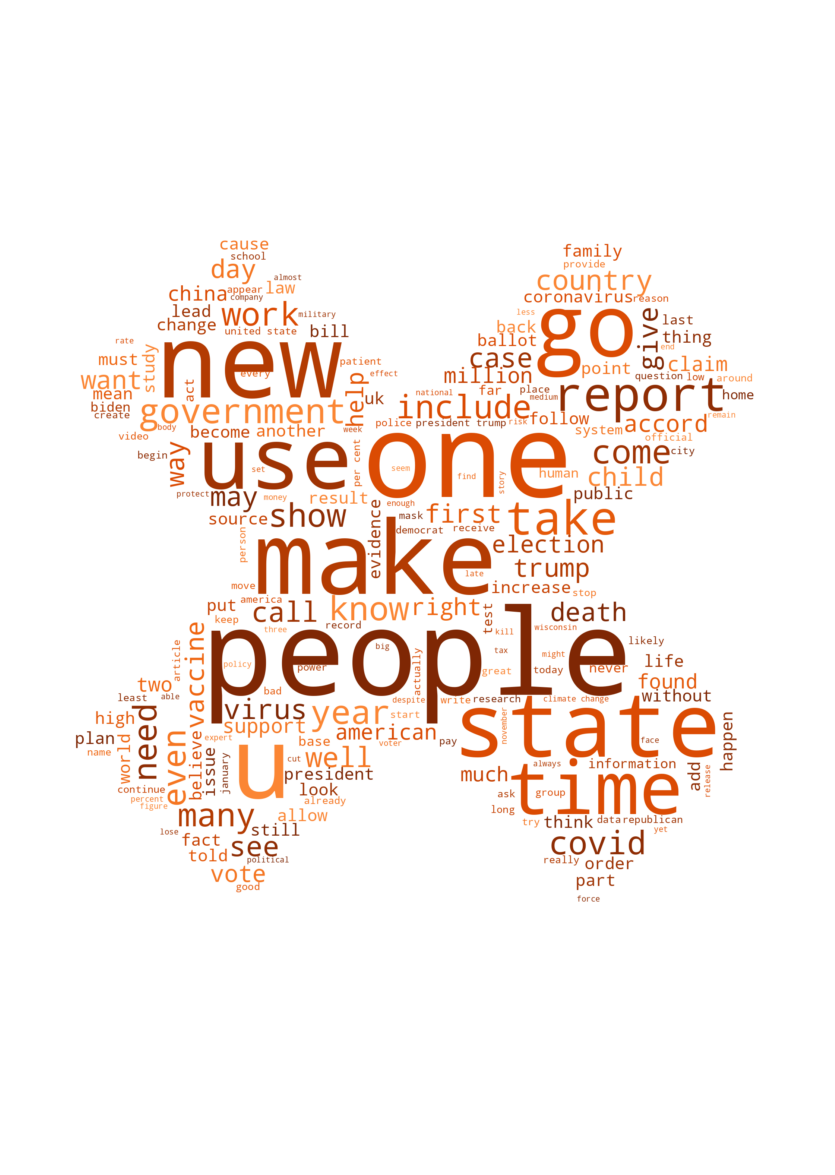

In [95]:
# WORD CLOUD FALSE VOC

cb_mask_FALSE = np.array(Image.open('croix.jpg'))

#Creating variable with data for this Word Cloud
temp = td_preprocessed1[td_preprocessed1['our rating'] == 'false']
textS = ' '.join(temp['text'].tolist())

cb_wc=WordCloud(width=400,height=200,mask=cb_mask_FALSE,random_state=101, max_font_size=450,
                 min_font_size=3,stopwords=stop_words,background_color="white",
                 scale=3,max_words=200,collocations=True,colormap=cmap_O)

#Generate it
cb_wc.generate(str(textS))

fig=plt.figure(figsize=(15,15))
plt.ylim(-400,2700)
plt.gca().invert_yaxis()
plt.axis("off")
plt.imshow(cb_wc,interpolation='bilinear')
plt.show()

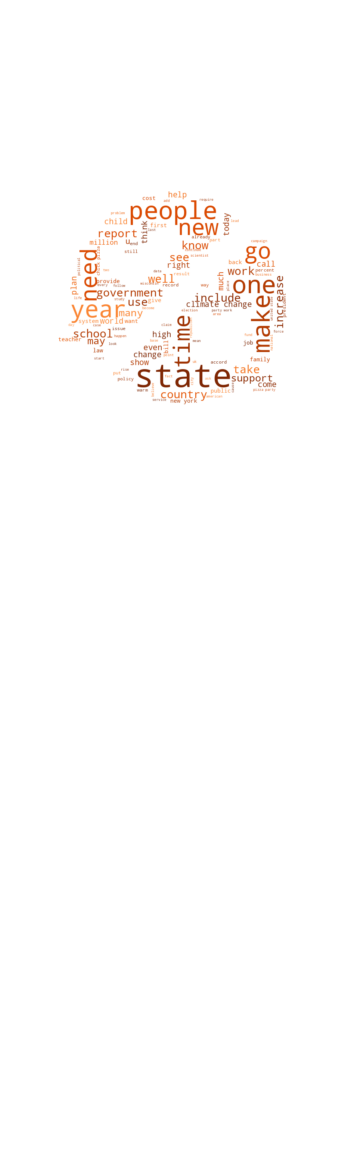

In [96]:
# WORD CLOUD MIXTURE

cb_mask_FALSE = np.array(Image.open('mixture.jpg'))

#Creating variable with data for this Word Cloud
temp = td_preprocessed1[td_preprocessed1['our rating'] == 'mixture']
textS = ' '.join(temp['text'].tolist())

cb_wc=WordCloud(width=400,height=200,mask=cb_mask_FALSE,random_state=101, max_font_size=450,
                 min_font_size=3,stopwords=stop_words,background_color="white",
                 scale=3,max_words=200,collocations=True,colormap=cmap_O)

#Generate it
cb_wc.generate(str(textS))

fig=plt.figure(figsize=(15,15))
plt.ylim(-400,2700)
plt.gca().invert_yaxis()
plt.axis("off")
plt.imshow(cb_wc,interpolation='bilinear')
plt.show()

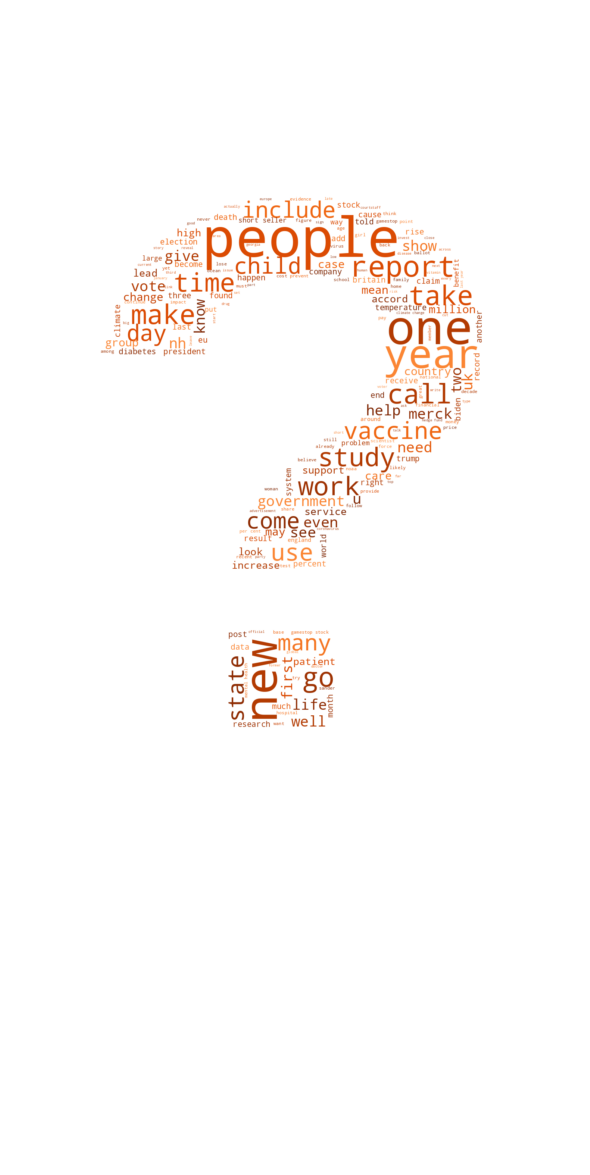

In [97]:
# WORD CLOUD OTHER

cb_mask_FALSE = np.array(Image.open('other.jpg'))

#Creating variable with data for this Word Cloud
temp = td_preprocessed1[td_preprocessed1['our rating'] == 'other']
textS = ' '.join(temp['text'].tolist())

cb_wc=WordCloud(width=400,height=200,mask=cb_mask_FALSE,random_state=101, max_font_size=450,
                 min_font_size=3,stopwords=stop_words,background_color="white",
                 scale=3,max_words=200,collocations=True,colormap=cmap_O)

#Generate it
cb_wc.generate(str(textS))

fig=plt.figure(figsize=(15,15))
plt.ylim(-400,2700)
plt.gca().invert_yaxis()
plt.axis("off")
plt.imshow(cb_wc,interpolation='bilinear')
plt.show()

## **Classifications**
**kNN**

**Naive Bayes**

**Logistic Regression**

**Decision Tree**

D'abord, on applique les mêmes transformations au testing data

In [98]:
test_data = pd.read_csv("HAI817_Projet_test.csv")
test_data.text = processContractions(test_data)
testd_preprocessed1 = test_data.copy();
testd_preprocessed1.text = preprocess1(test_data);

testd_preprocessed2 = test_data.copy();
testd_preprocessed2.text = preprocess2(test_data);

### TF-IDF / Count vectorizer

In [212]:
# comment/uncomment ci-dessous pour faire changer de vectorizer

#cv = TfidfVectorizer(max_df=0.8, min_df=0.2, ngram_range=(1,3))
#cv = TfidfVectorizer(ngram_range=(2,2))
cv = TfidfVectorizer()
#cv = CountVectorizer()

# CATEGORIE A: True vs False vs Mixture vs Other
X_traincv1_A = td_preprocessed1.text
y_traincv1_A = td_preprocessed1['our rating']
X_testcv1_A = testd_preprocessed1.text
y_testcv1_A = testd_preprocessed1['our rating']

X_traincv1_A = cv.fit_transform(X_traincv1_A)
X_testcv1_A = cv.transform(X_testcv1_A)

# CATEGORIE B: True vs False
X_traincv1_B = td_preprocessed1.loc[((td_preprocessed1['our rating'] == 'true' ) | (td_preprocessed1['our rating'] == 'false'))].text
y_traincv1_B = td_preprocessed1.loc[((td_preprocessed1['our rating'] == 'true' ) | (td_preprocessed1['our rating'] == 'false'))]['our rating']
X_testcv1_B = testd_preprocessed1.loc[((testd_preprocessed1['our rating'] == 'true' ) | (testd_preprocessed1['our rating'] == 'false'))].text
y_testcv1_B = testd_preprocessed1.loc[((testd_preprocessed1['our rating'] == 'true' ) | (testd_preprocessed1['our rating'] == 'false'))]['our rating']

X_traincv1_B = cv.fit_transform(X_traincv1_B)
X_testcv1_B = cv.transform(X_testcv1_B)

# CATEGORIE C: True/False vs Other/Mixture
td_TFvO = td_preprocessed1.copy(True);
td_TFvO.loc[((td_preprocessed1['our rating'] == 'true' ) | (td_preprocessed1['our rating'] == 'false')), 'our rating'] = 'tf'
testd_TFvO = testd_preprocessed1.copy(True);
testd_TFvO.loc[((testd_preprocessed1['our rating'] == 'true' ) | (testd_preprocessed1['our rating'] == 'false')), 'our rating'] = 'tf'

td_TFvOBis = td_preprocessed1.copy(True);
td_TFvOBis.loc[((td_preprocessed1['our rating'] == 'other' ) | (td_preprocessed1['our rating'] == 'mixture')), 'our rating'] = 'om'
testd_TFvOBis = testd_preprocessed1.copy(True);
testd_TFvOBis.loc[((testd_preprocessed1['our rating'] == 'other' ) | (testd_preprocessed1['our rating'] == 'mixture')), 'our rating'] = 'om'

X_traincv1_C = td_TFvO.loc[((td_TFvO['our rating'] == 'tf' )|( td_TFvOBis['our rating'] == 'om'))].text
y_traincv1_C = td_TFvO.loc[((td_TFvO['our rating'] == 'tf') | (td_TFvOBis['our rating'] == 'om'))]['our rating']
X_testcv1_C = testd_TFvO.loc[((testd_TFvO['our rating'] == 'tf') | (testd_TFvOBis['our rating'] == 'om'))].text
y_testcv1_C = testd_TFvO.loc[((testd_TFvO['our rating'] == 'tf') | (testd_TFvOBis['our rating'] == 'om'))]['our rating']

X_traincv1_C = cv.fit_transform(X_traincv1_C)
X_testcv1_C = cv.transform(X_testcv1_C)

Maintenant, on fait la même chose mais pour la deuxième méthode de préprocessing (càd sans la lemmatization)

In [213]:
# CATEGORIE A: True vs False vs Mixture vs Other
X_traincv2_A = td_preprocessed2.text
y_traincv2_A = td_preprocessed2['our rating']
X_testcv2_A = testd_preprocessed2.text
y_testcv2_A = testd_preprocessed2['our rating']

X_traincv2_A = cv.fit_transform(X_traincv2_A)
X_testcv2_A = cv.transform(X_testcv2_A)

# CATEGORIE B: True vs False
X_traincv2_B = td_preprocessed2.loc[((td_preprocessed2['our rating'] == 'true' ) | (td_preprocessed2['our rating'] == 'false'))].text
y_traincv2_B = td_preprocessed2.loc[((td_preprocessed2['our rating'] == 'true' ) | (td_preprocessed2['our rating'] == 'false'))]['our rating']
X_testcv2_B = testd_preprocessed2.loc[((testd_preprocessed2['our rating'] == 'true' ) | (testd_preprocessed2['our rating'] == 'false'))].text
y_testcv2_B = testd_preprocessed2.loc[((testd_preprocessed2['our rating'] == 'true' ) | (testd_preprocessed2['our rating'] == 'false'))]['our rating']

X_traincv2_B = cv.fit_transform(X_traincv2_B)
X_testcv2_B = cv.transform(X_testcv2_B)

# CATEGORIE C: True/False vs Other
td_TFvO2 = td_preprocessed2.copy(True);
td_TFvO2.loc[((td_preprocessed2['our rating'] == 'true' ) | (td_preprocessed2['our rating'] == 'false')), 'our rating'] = 'tf'
testd_TFvO2 = testd_preprocessed2.copy(True);
testd_TFvO.loc[((testd_preprocessed2['our rating'] == 'true' ) | (testd_preprocessed2['our rating'] == 'false')), 'our rating'] = 'tf'
X_traincv2_C = td_TFvO2.loc[((td_TFvO2['our rating'] == 'tf' )|( td_TFvO2['our rating'] == 'other'))].text
y_traincv2_C = td_TFvO2.loc[((td_TFvO2['our rating'] == 'tf') | (td_TFvO2['our rating'] == 'other'))]['our rating']
X_testcv2_C = testd_TFvO2.loc[((testd_TFvO2['our rating'] == 'tf') | (testd_TFvO2['our rating'] == 'other'))].text
y_testcv2_C = testd_TFvO2.loc[((testd_TFvO2['our rating'] == 'tf') | (testd_TFvO2['our rating'] == 'other'))]['our rating']

X_traincv2_C = cv.fit_transform(X_traincv2_C)
X_testcv2_C = cv.transform(X_testcv2_C)

### kNN

In [214]:
model = KNeighborsClassifier(n_neighbors=3, p=1) # take odd nr > 2 to avoid tights

model.fit(X_traincv1_A, y_traincv1_A)

y_pred_train = model.predict(X_traincv1_A)
y_pred_test = model.predict(X_testcv1_A)

print('Accuracy on training data =', accuracy_score(y_traincv1_A, y_pred_train))
print('Accuracy on testing data =', accuracy_score(y_testcv1_A, y_pred_test))
print('')
print(metrics.classification_report(y_testcv1_A, y_pred_test))

Accuracy on training data = 0.7919303797468354
Accuracy on testing data = 0.5147058823529411

              precision    recall  f1-score   support

       false       0.51      1.00      0.68       315
     mixture       0.00      0.00      0.00        56
       other       0.00      0.00      0.00        31
        true       0.00      0.00      0.00       210

    accuracy                           0.51       612
   macro avg       0.13      0.25      0.17       612
weighted avg       0.26      0.51      0.35       612



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [215]:
model = KNeighborsClassifier(n_neighbors=3, p=1) # take odd nr > 2 to avoid tights

model.fit(X_traincv1_B, y_traincv1_B)

y_pred_train = model.predict(X_traincv1_B)
y_pred_test = model.predict(X_testcv1_B)

print('Accuracy on training data =', accuracy_score(y_traincv1_B, y_pred_train))
print('Accuracy on testing data =', accuracy_score(y_testcv1_B, y_pred_test))
print('')
print(metrics.classification_report(y_testcv1_B, y_pred_test))

Accuracy on training data = 0.779467680608365
Accuracy on testing data = 0.6

              precision    recall  f1-score   support

       false       0.60      1.00      0.75       315
        true       0.00      0.00      0.00       210

    accuracy                           0.60       525
   macro avg       0.30      0.50      0.37       525
weighted avg       0.36      0.60      0.45       525



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [216]:
model = KNeighborsClassifier(n_neighbors=3, p=1) # take odd nr > 2 to avoid tights
# d'autres valeurs pour n_neighbors ont été testées, 3 s'est avéré la meilleure

model.fit(X_traincv1_C, y_traincv1_C)

y_pred_train = model.predict(X_traincv1_C)
y_pred_test = model.predict(X_testcv1_C)

print('Accuracy on training data =', accuracy_score(y_traincv1_C, y_pred_train))
print('Accuracy on testing data =', accuracy_score(y_testcv1_C, y_pred_test))
print('')
print(metrics.classification_report(y_testcv1_C, y_pred_test))

Accuracy on training data = 0.928006329113924
Accuracy on testing data = 0.8578431372549019

              precision    recall  f1-score   support

     mixture       0.00      0.00      0.00        56
       other       0.00      0.00      0.00        31
          tf       0.86      1.00      0.92       525

    accuracy                           0.86       612
   macro avg       0.29      0.33      0.31       612
weighted avg       0.74      0.86      0.79       612



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Naive Bayes

In [217]:
model = MultinomialNB(alpha=0, force_alpha=True) # no smoothing

model.fit(X_traincv1_A, y_traincv1_A)

y_pred_train = model.predict(X_traincv1_A)
y_pred_test = model.predict(X_testcv1_A)

print('Accuracy on training data =', accuracy_score(y_traincv1_A, y_pred_train))
print('Accuracy on testing data =', accuracy_score(y_testcv1_A, y_pred_test))
print('')
print(metrics.classification_report(y_testcv1_A, y_pred_test))

Accuracy on training data = 0.9849683544303798
Accuracy on testing data = 0.5163398692810458

              precision    recall  f1-score   support

       false       0.52      1.00      0.68       315
     mixture       0.00      0.00      0.00        56
       other       0.00      0.00      0.00        31
        true       1.00      0.01      0.02       210

    accuracy                           0.52       612
   macro avg       0.38      0.25      0.17       612
weighted avg       0.61      0.52      0.36       612



/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:907: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. 

In [218]:
model = MultinomialNB(alpha=0, force_alpha=True) # no smoothing

model.fit(X_traincv1_B, y_traincv1_B)

y_pred_train = model.predict(X_traincv1_B)
y_pred_test = model.predict(X_testcv1_B)

print('Accuracy on training data =', accuracy_score(y_traincv1_B, y_pred_train))
print('Accuracy on testing data =', accuracy_score(y_testcv1_B, y_pred_test))
print('')
print(metrics.classification_report(y_testcv1_B, y_pred_test))

Accuracy on training data = 0.9949302915082383
Accuracy on testing data = 0.6076190476190476

              precision    recall  f1-score   support

       false       0.61      1.00      0.75       315
        true       0.83      0.02      0.05       210

    accuracy                           0.61       525
   macro avg       0.72      0.51      0.40       525
weighted avg       0.70      0.61      0.47       525



/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:907: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(


In [219]:
model = MultinomialNB(alpha=0, force_alpha=True) # no smoothing

model.fit(X_traincv1_C, y_traincv1_C)

y_pred_train = model.predict(X_traincv1_C)
y_pred_test = model.predict(X_testcv1_C)

print('Accuracy on training data =', accuracy_score(y_traincv1_C, y_pred_train))
print('Accuracy on testing data =', accuracy_score(y_testcv1_C, y_pred_test))
print('')
print(metrics.classification_report(y_testcv1_C, y_pred_test))

Accuracy on training data = 0.990506329113924
Accuracy on testing data = 0.24019607843137256

              precision    recall  f1-score   support

     mixture       0.09      0.80      0.16        56
       other       0.00      0.00      0.00        31
          tf       0.86      0.19      0.32       525

    accuracy                           0.24       612
   macro avg       0.32      0.33      0.16       612
weighted avg       0.74      0.24      0.29       612



/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:907: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. 

### Logistic Regression

In [220]:
model = LogisticRegression(max_iter=1000)

lr = model.fit(X_traincv1_A, y_traincv1_A)

y_pred_train = lr.predict(X_traincv1_A)
y_pred_test = lr.predict(X_testcv1_A)

print('Accuracy on training data =', accuracy_score(y_traincv1_A, y_pred_train))
print('Accuracy on testing data =', accuracy_score(y_testcv1_A, y_pred_test))
print('')
print(metrics.classification_report(y_testcv1_A, y_pred_test))

Accuracy on training data = 0.8251582278481012
Accuracy on testing data = 0.5065359477124183

              precision    recall  f1-score   support

       false       0.54      0.95      0.69       315
     mixture       0.11      0.11      0.11        56
       other       0.00      0.00      0.00        31
        true       0.80      0.02      0.04       210

    accuracy                           0.51       612
   macro avg       0.36      0.27      0.21       612
weighted avg       0.56      0.51      0.38       612



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [221]:
model = LogisticRegression(max_iter=1000)

lr = model.fit(X_traincv1_B, y_traincv1_B)

y_pred_train = lr.predict(X_traincv1_B)
y_pred_test = lr.predict(X_testcv1_B)

print('Accuracy on training data =', accuracy_score(y_traincv1_B, y_pred_train))
print('Accuracy on testing data =', accuracy_score(y_testcv1_B, y_pred_test))
print('')
print(metrics.classification_report(y_testcv1_B, y_pred_test))

Accuracy on training data = 0.8415716096324461
Accuracy on testing data = 0.6190476190476191

              precision    recall  f1-score   support

       false       0.61      0.99      0.76       315
        true       0.86      0.06      0.11       210

    accuracy                           0.62       525
   macro avg       0.73      0.53      0.43       525
weighted avg       0.71      0.62      0.50       525



In [222]:
model = LogisticRegression(max_iter=1000)

lr = model.fit(X_traincv1_C, y_traincv1_C)

y_pred_train = lr.predict(X_traincv1_C)
y_pred_test = lr.predict(X_testcv1_C)

print('Accuracy on training data =', accuracy_score(y_traincv1_C, y_pred_train))
print('Accuracy on testing data =', accuracy_score(y_testcv1_C, y_pred_test))
print('')
print(metrics.classification_report(y_testcv1_C, y_pred_test))

Accuracy on training data = 0.8330696202531646
Accuracy on testing data = 0.8431372549019608

              precision    recall  f1-score   support

     mixture       0.09      0.02      0.03        56
       other       0.00      0.00      0.00        31
          tf       0.86      0.98      0.91       525

    accuracy                           0.84       612
   macro avg       0.32      0.33      0.31       612
weighted avg       0.74      0.84      0.79       612



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Decision Tree


In [ ]:
grid_param = {'max_depth': [50],'criterion': ['gini', 'entropy'],'min_samples_leaf': [5]}

gd_sr = GridSearchCV(estimator=DecisionTreeClassifier(),
param_grid=grid_param,
scoring='accuracy',
cv=10,
n_jobs=-1,
return_train_score=True)
dt = gd_sr.fit(X_traincv1_A, y_traincv1_A)

y_pred_train = dt.predict(X_traincv1_A)
y_pred_test = dt.predict(X_testcv1_A)

print('Accuracy on training data =', accuracy_score(y_traincv1_A, y_pred_train))
print('Accuracy on testing data =', accuracy_score(y_testcv1_A, y_pred_test))
print('')
print(metrics.classification_report(y_testcv1_A, y_pred_test))

In [ ]:
dt = gd_sr.fit(X_traincv1_B, y_traincv1_B)

y_pred_train = dt.predict(X_traincv1_B)
y_pred_test = dt.predict(X_testcv1_B)

print('Accuracy on training data =', accuracy_score(y_traincv1_B, y_pred_train))
print('Accuracy on testing data =', accuracy_score(y_testcv1_B, y_pred_test))
print('')

In [ ]:
dt = gd_sr.fit(X_traincv1_C, y_traincv1_C)

y_pred_train = dt.predict(X_traincv1_C)
y_pred_test = dt.predict(X_testcv1_C)

print('Accuracy on training data =', accuracy_score(y_traincv1_C, y_pred_train))
print('Accuracy on testing data =', accuracy_score(y_testcv1_C, y_pred_test))
print('')

### Random Forest


In [ ]:
# Random forest
model = RandomForestClassifier(random_state=42)

rf = model.fit(X_traincv1_B, y_traincv1_B)

y_pred_train = rf.predict(X_traincv1_B)
y_pred_test = rf.predict(X_testcv1_B)

print('Accuracy on training data =', metrics.accuracy_score(y_traincv1_B, y_pred_train))
print('Accuracy on test data =', metrics.accuracy_score(y_testcv1_B, y_pred_test))
print('')
print(metrics.classification_report(y_testcv1_B, y_pred_test))

## Test résultats

Dans cette section on va tester plein de choses pour tenter d'améliorer les résultats.

In [225]:
model = KNeighborsClassifier(n_neighbors=3, p=1) # take odd nr > 2 to avoid tights

model.fit(X_traincv2_B, y_traincv2_B)

y_pred_train = model.predict(X_traincv2_B)
y_pred_test = model.predict(X_testcv2_B)

print('Accuracy on training data =', accuracy_score(y_traincv2_B, y_pred_train))
print('Accuracy on testing data =', accuracy_score(y_testcv2_B, y_pred_test))
print('')
print(metrics.classification_report(y_testcv2_B, y_pred_test))

Accuracy on training data = 0.779467680608365
Accuracy on testing data = 0.6

              precision    recall  f1-score   support

       false       0.60      1.00      0.75       315
        true       0.00      0.00      0.00       210

    accuracy                           0.60       525
   macro avg       0.30      0.50      0.37       525
weighted avg       0.36      0.60      0.45       525



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [226]:
model = MultinomialNB(alpha=0.01)

model.fit(X_traincv2_B, y_traincv2_B)

y_pred_train = model.predict(X_traincv2_B)
y_pred_test = model.predict(X_testcv2_B)

print('Accuracy on training data =', accuracy_score(y_traincv2_B, y_pred_train))
print('Accuracy on testing data =', accuracy_score(y_testcv2_B, y_pred_test))
print('')
print(metrics.classification_report(y_testcv2_B, y_pred_test))

Accuracy on training data = 0.991128010139417
Accuracy on testing data = 0.6704761904761904

              precision    recall  f1-score   support

       false       0.65      0.96      0.78       315
        true       0.80      0.23      0.36       210

    accuracy                           0.67       525
   macro avg       0.73      0.60      0.57       525
weighted avg       0.71      0.67      0.61       525



In [227]:
model = MultinomialNB(alpha=0.01)

model.fit(X_traincv2_A, y_traincv2_A)

y_pred_train = model.predict(X_traincv2_A)
y_pred_test = model.predict(X_testcv2_A)

print('Accuracy on training data =', accuracy_score(y_traincv2_A, y_pred_train))
print('Accuracy on testing data =', accuracy_score(y_testcv2_A, y_pred_test))
print('')
print(metrics.classification_report(y_testcv2_A, y_pred_test))

Accuracy on training data = 0.9762658227848101
Accuracy on testing data = 0.5245098039215687

              precision    recall  f1-score   support

       false       0.58      0.92      0.71       315
     mixture       0.17      0.25      0.20        56
       other       0.00      0.00      0.00        31
        true       0.67      0.09      0.15       210

    accuracy                           0.52       612
   macro avg       0.35      0.31      0.27       612
weighted avg       0.54      0.52      0.44       612



In [228]:
dt = gd_sr.fit(X_traincv2_B, y_traincv2_B)

y_pred_train = dt.predict(X_traincv2_B)
y_pred_test = dt.predict(X_testcv2_B)

print('Accuracy on training data =', accuracy_score(y_traincv2_B, y_pred_train))
print('Accuracy on testing data =', accuracy_score(y_testcv2_B, y_pred_test))
print('')

Accuracy on training data = 0.9721166032953105
Accuracy on testing data = 0.5828571428571429



### Downsampling / upsampling



Problème de déséquilibre des classes dans notre training data ? On va donc voir on a combien de documents classés comme Vrai et combien comme Faux.

In [229]:
true_count = (td_preprocessed1['our rating'] == 'true').value_counts(normalize=False)[True]
false_count = (td_preprocessed1['our rating'] == 'false').value_counts(normalize=False)[True]
other_count = (td_preprocessed1['our rating'] == 'other').value_counts(normalize=False)[True]
mix_count = (td_preprocessed1['our rating'] == 'mixture').value_counts(normalize=False)[True]
print(true_count)
print(false_count)
print(other_count)
print(mix_count)

211
578
117
358


Effectivement il y a un gros déséquilibre, on va donc faire du downsampling pour avoir 211 articles vrais et 211 articles faux. Cela devrait améliorer nos résultats.

In [230]:
# Créer dataframe qui contient que les documents True ou False
td_p1_TF = td_preprocessed1.loc[((td_preprocessed1['our rating'] == 'true' ) | (td_preprocessed1['our rating'] == 'false'))]
count_labels = td_p1_TF.groupby('our rating').count()

# DOWNSAMPLING
# categorie B (True vs False)
n_samples = count_labels.min().iloc[0]

td_p1_TF_down = td_p1_TF.groupby('our rating').apply(lambda x: x.sample(n_samples)).reset_index(drop=True)

true_count_down = (td_p1_TF_down['our rating'] == 'true').value_counts(normalize=False)[True]
false_count_down = (td_p1_TF_down['our rating'] == 'false').value_counts(normalize=False)[True]
print(true_count_down)
print(false_count_down)

211
211


In [231]:
# UPSAMPLING
# categorie B

n_samples = count_labels.max().iloc[0]
td_p1_TF_up = td_p1_TF.groupby('our rating').apply(lambda x: resample(x, random_state=1, replace=True, n_samples=n_samples))

true_count_up = (td_p1_TF_up['our rating'] == 'true').value_counts(normalize=False)[True]
false_count_up = (td_p1_TF_up['our rating'] == 'false').value_counts(normalize=False)[True]
print(true_count_up)
print(false_count_up)

578
578


In [232]:
# Up and Down sampling
# Categorie B

n_samples = count_labels.max().iloc[0] - int((count_labels.max().iloc[0] - count_labels.min().iloc[0])/2)
td_p1_TF_balanced = td_p1_TF.groupby('our rating').apply(lambda x: resample(x, random_state=1, replace=True, n_samples=n_samples))

true_count_balanced = (td_p1_TF_balanced['our rating'] == 'true').value_counts(normalize=False)[True]
false_count_balanced = (td_p1_TF_balanced['our rating'] == 'false').value_counts(normalize=False)[True]
print(true_count_balanced)
print(false_count_balanced)

395
395


In [233]:
# Train with upsampling

X_traincv1_B_up= td_p1_TF_up.text
y_traincv1_B_up = td_p1_TF_up['our rating']
X_testcv1_B = testd_preprocessed1.loc[((testd_preprocessed1['our rating'] == 'true' ) | (testd_preprocessed1['our rating'] == 'false'))].text
y_testcv1_B = testd_preprocessed1.loc[((testd_preprocessed1['our rating'] == 'true' ) | (testd_preprocessed1['our rating'] == 'false'))]['our rating']

X_traincv1_B_up = cv.fit_transform(X_traincv1_B_up)
X_testcv1_B = cv.transform(X_testcv1_B)

# NB
model = MultinomialNB(alpha=0, force_alpha=True) # no smoothing

model.fit(X_traincv1_B_up, y_traincv1_B_up)

y_pred_train = model.predict(X_traincv1_B_up)
y_pred_test = model.predict(X_testcv1_B)

print('Accuracy on training data =', accuracy_score(y_traincv1_B_up, y_pred_train))
print('Accuracy on testing data =', accuracy_score(y_testcv1_B, y_pred_test))
print('')
print(metrics.classification_report(y_testcv1_B, y_pred_test))

Accuracy on training data = 0.9974048442906575
Accuracy on testing data = 0.6019047619047619

              precision    recall  f1-score   support

       false       0.60      0.99      0.75       315
        true       0.57      0.02      0.04       210

    accuracy                           0.60       525
   macro avg       0.59      0.50      0.39       525
weighted avg       0.59      0.60      0.46       525



/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:907: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(


In [234]:
# Train with downsampling

X_traincv1_B_down= td_p1_TF_down.text
y_traincv1_B_down = td_p1_TF_down['our rating']
X_testcv1_B = testd_preprocessed1.loc[((testd_preprocessed1['our rating'] == 'true' ) | (testd_preprocessed1['our rating'] == 'false'))].text
y_testcv1_B = testd_preprocessed1.loc[((testd_preprocessed1['our rating'] == 'true' ) | (testd_preprocessed1['our rating'] == 'false'))]['our rating']

X_traincv1_B_down = cv.fit_transform(X_traincv1_B_down)
X_testcv1_B = cv.transform(X_testcv1_B)

# NB
model = MultinomialNB(alpha=0, force_alpha=True) # no smoothing

model.fit(X_traincv1_B_down, y_traincv1_B_down)

y_pred_train = model.predict(X_traincv1_B_down)
y_pred_test = model.predict(X_testcv1_B)

print('Accuracy on training data =', accuracy_score(y_traincv1_B_down, y_pred_train))
print('Accuracy on testing data =', accuracy_score(y_testcv1_B, y_pred_test))
print('')
print(metrics.classification_report(y_testcv1_B, y_pred_test))

Accuracy on training data = 0.9976303317535545
Accuracy on testing data = 0.6095238095238096

              precision    recall  f1-score   support

       false       0.61      0.99      0.75       315
        true       0.69      0.04      0.08       210

    accuracy                           0.61       525
   macro avg       0.65      0.52      0.42       525
weighted avg       0.64      0.61      0.48       525



/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:907: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(


In [243]:
# Train with up+downsampling

X_traincv1_B_balanced = td_p1_TF_balanced.text
y_traincv1_B_balanced = td_p1_TF_balanced['our rating']
X_testcv1_B = testd_preprocessed1.loc[((testd_preprocessed1['our rating'] == 'true' ) | (testd_preprocessed1['our rating'] == 'false'))].text
y_testcv1_B = testd_preprocessed1.loc[((testd_preprocessed1['our rating'] == 'true' ) | (testd_preprocessed1['our rating'] == 'false'))]['our rating']

X_traincv1_B_balanced = cv.fit_transform(X_traincv1_B_balanced)
X_testcv1_B = cv.transform(X_testcv1_B)

# NB
model = MultinomialNB(alpha=0, force_alpha=True) # no smoothing

model.fit(X_traincv1_B_balanced, y_traincv1_B_balanced)

y_pred_train = model.predict(X_traincv1_B_balanced)
y_pred_test = model.predict(X_testcv1_B)

print('Accuracy on training data =', accuracy_score(y_traincv1_B_balanced, y_pred_train))
print('Accuracy on testing data =', accuracy_score(y_testcv1_B, y_pred_test))
print('')
print(metrics.classification_report(y_testcv1_B, y_pred_test))

Accuracy on training data = 0.9987341772151899
Accuracy on testing data = 0.6019047619047619

              precision    recall  f1-score   support

       false       0.60      0.99      0.75       315
        true       0.57      0.02      0.04       210

    accuracy                           0.60       525
   macro avg       0.59      0.50      0.39       525
weighted avg       0.59      0.60      0.46       525



/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:907: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(


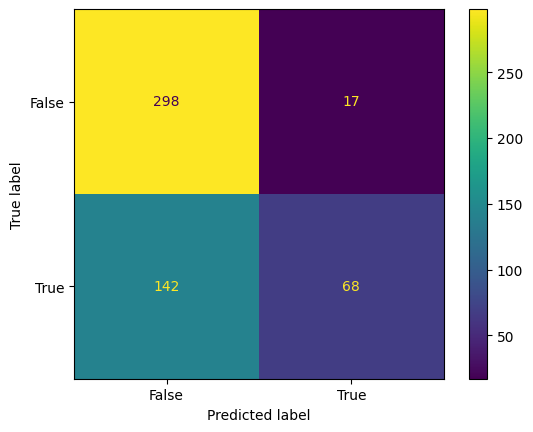

In [236]:
confusion_matrix = metrics.confusion_matrix(y_testcv1_B, y_pred_test)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

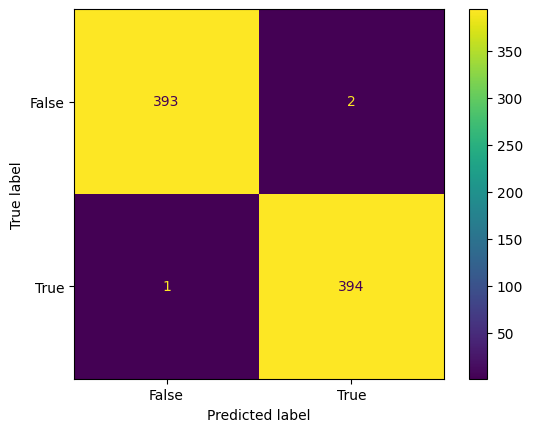

In [237]:
confusion_matrix = metrics.confusion_matrix(y_traincv1_B_balanced, y_pred_train)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [238]:
# LR
model = LogisticRegression(max_iter=1000)

lr = model.fit(X_traincv1_B_balanced, y_traincv1_B_balanced)

y_pred_train = lr.predict(X_traincv1_B_balanced)
y_pred_test = lr.predict(X_testcv1_B)


print('Accuracy on training data =', accuracy_score(y_traincv1_B_balanced, y_pred_train))
print('Accuracy on testing data =', accuracy_score(y_testcv1_B, y_pred_test))
print('')
print(metrics.classification_report(y_testcv1_B, y_pred_test))

Accuracy on training data = 0.9658227848101266
Accuracy on testing data = 0.6685714285714286

              precision    recall  f1-score   support

       false       0.66      0.92      0.77       315
        true       0.71      0.29      0.41       210

    accuracy                           0.67       525
   macro avg       0.69      0.60      0.59       525
weighted avg       0.68      0.67      0.63       525



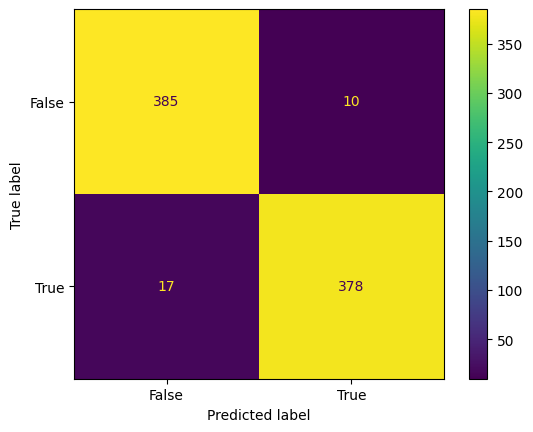

In [239]:
confusion_matrix = metrics.confusion_matrix(y_traincv1_B_balanced, y_pred_train)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [240]:
# Random forest
n_estimators = 1000
min_samples_split = 10
min_samples_leaf = 1
max_depth = None
bootstrap = False
best_model = RandomForestClassifier(n_estimators=n_estimators, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_depth=max_depth, bootstrap=bootstrap)

y_pred_train = lr.predict(X_traincv1_B_balanced)
y_pred_test = lr.predict(X_testcv1_B)


print('Accuracy on training data =', accuracy_score(y_traincv1_B_balanced, y_pred_train))
print('Accuracy on testing data =', accuracy_score(y_testcv1_B, y_pred_test))
print('')
print(metrics.classification_report(y_testcv1_B, y_pred_test))

Accuracy on training data = 0.9658227848101266
Accuracy on testing data = 0.6685714285714286

              precision    recall  f1-score   support

       false       0.66      0.92      0.77       315
        true       0.71      0.29      0.41       210

    accuracy                           0.67       525
   macro avg       0.69      0.60      0.59       525
weighted avg       0.68      0.67      0.63       525



Best parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best score: 0.7325868224602402


<ipython-input-241-66f5368248e9>:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


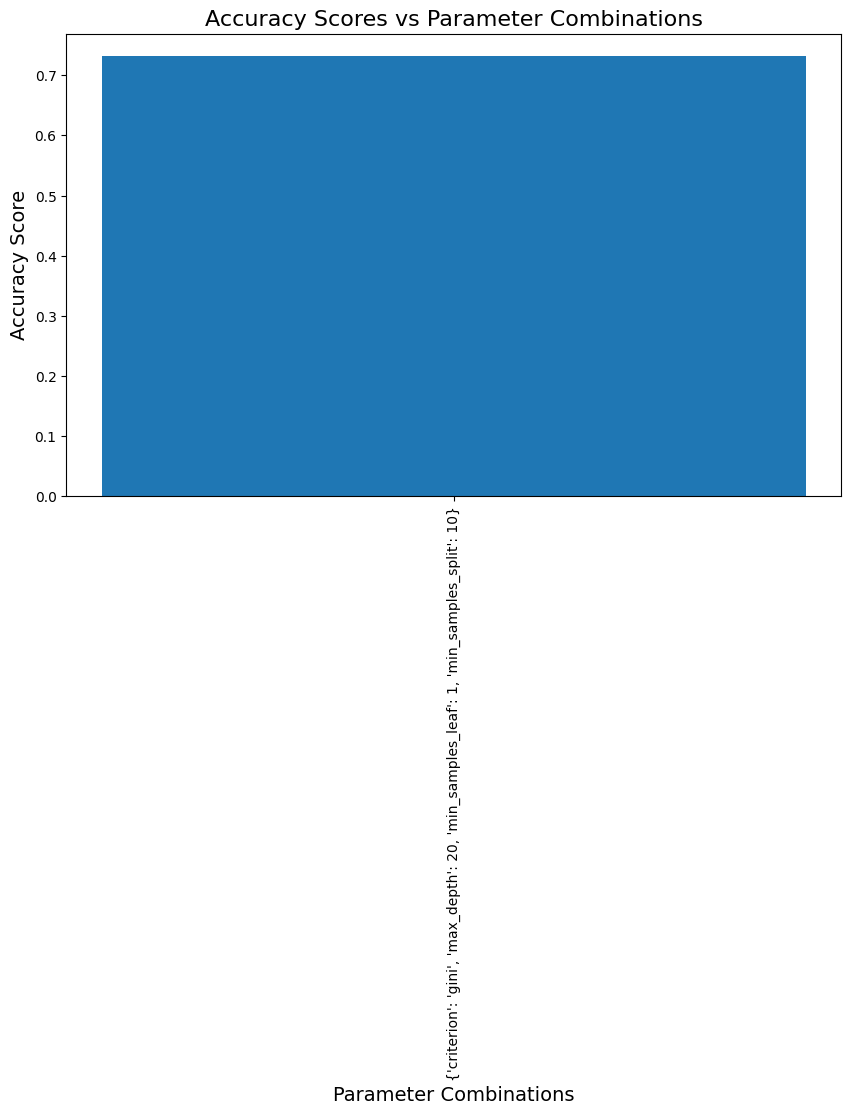

In [241]:
# a la recherche des meilleurs paramètres pour decision tree

grid_param = {
'max_depth': [7, 10, 20, 50],
'min_samples_split': [10, 20],
'criterion': ['gini', 'entropy'],
'min_samples_leaf': [1,5,10]
}

# Get the accuracy scores for all parameter combinations
scores = gd_sr.cv_results_['mean_test_score']

# Print the best parameters and the corresponding score
print("Best parameters:", gd_sr.best_params_)
print("Best score:", gd_sr.best_score_)

# Create a plot of the accuracy scores vs the different parameter combinations
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Accuracy Scores vs Parameter Combinations", fontsize=16)
ax.set_xlabel("Parameter Combinations", fontsize=14)
ax.set_ylabel("Accuracy Score", fontsize=14)
ax.bar(range(len(scores)), scores)
ax.set_xticks(range(len(scores)))
ax.set_xticklabels([str(params) for params in gd_sr.cv_results_['params']], rotation=90)
plt.tight_layout()
plt.show()

In [242]:
# decision tree, up + down sampling, best parameters
grid_param = {'criterion': ['gini'], 'max_depth': [20], 'min_samples_leaf': [1], 'min_samples_split': [10]}

gd_sr = GridSearchCV(estimator=DecisionTreeClassifier(),
param_grid=grid_param,
scoring='accuracy',
cv=10,
n_jobs=-1,
return_train_score=True)

dt = gd_sr.fit(X_traincv1_B_balanced, y_traincv1_B_balanced)

y_pred_train = dt.predict(X_traincv1_B_balanced)
y_pred_test = dt.predict(X_testcv1_B)

print('Accuracy on training data =', accuracy_score(y_traincv1_B_balanced, y_pred_train))
print('Accuracy on testing data =', accuracy_score(y_testcv1_B, y_pred_test))
print('')

Accuracy on training data = 0.9886075949367089
Accuracy on testing data = 0.5923809523809523

